<a href="https://colab.research.google.com/github/LizLian/from_scratch_2025/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math

In [32]:
class Value:
  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None # by default this function does nothing
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    # called by print
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    # called by addition operator
    out = Value(self.data+other.data, (self, other), "+")
    def _backward():
      self.grad  += 1.0 * out.grad # route gradients back to operants in addtion
      other.grad += 1.0 * out.grad
    out._backward = _backward # we want to store the function not calling the function becuase the function returns None.
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    # called internally by mulipilication operator
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f"**{other}")

    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), "exp")

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [4]:
# @title visualize the graph
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d*f; L.label="L"
L

Value(data=-8.0)

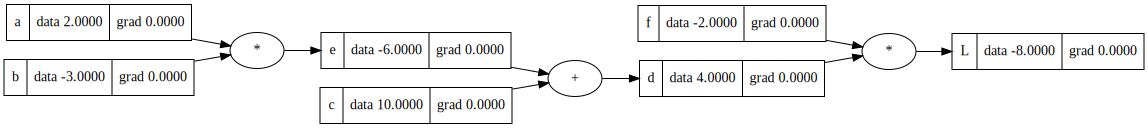

In [6]:
draw_dot(L)

In [7]:
# L = d * f
# definition of derivative (f(x+h)-f(x))/h)
# dL/dd = (f(x+h)-f(x))/h = ((d+h)*f - d*f)/h = f = -2.0

# dL/dc -> chain rule -> dL/dd * dd/dc = -0.2*1.0
# d = c + e
# dd / dc -> (f(x+h)-f(x))/h -> ((c+e+h)-(c+e))/h = 1.0
# dd / de = 1.0

# dL/da = dL/de * de/da


L.grad = 1.0
d.grad = -2.0 # (dL/dd)
c.grad = -2.0 # dL/dc
e.grad = -2.0 # dL/de
a.grad = -2.0*(-3)
b.grad = -2.0*(2)

In [8]:
def lol():
  # testing the derivative if the function is increase by a small h
  h = 0.0001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b
  e.label = "e"
  d = e + c
  d.label = "d"
  f = Value(-2.0, label="f")
  L = d*f; L.label="L"
  L1 = L.data

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b
  e.label = "e"
  d = e + c
  d.label = "d"
  f = Value(-2.0, label="f")
  f.data += h # +h to test dL/df
  L = d*f; L.label="L"
  L2 = L.data # +h to test dL/dL

  print((L2-L1)/h)

lol()

3.9999999999995595


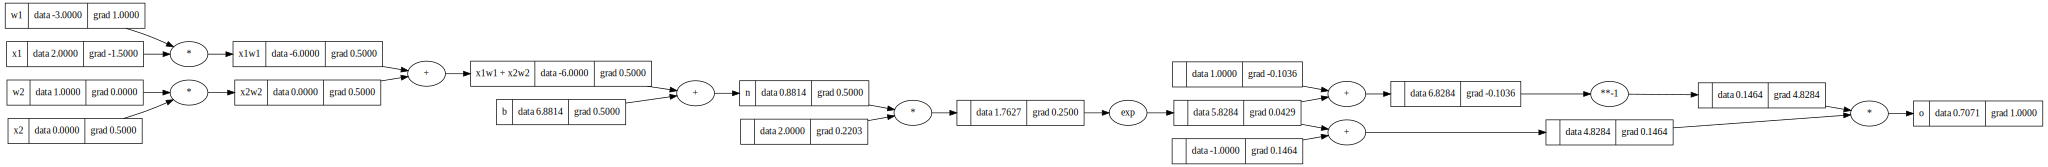

In [9]:
# implement neuron
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
# ----
e = (2*n).exp()
o = (e-1)/(e+1)
# ----
o.label = "o"
o.backward()
draw_dot(o)

In [10]:
# do/dx2(x2.grad) = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx2w2 * dx2w2/dx2 = x2w2.grad * dx2w2/dx2 = x2w2.grad * w2.data


In [11]:
o.grad = 1.0

In [12]:
#@title manually calling the backward function
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [13]:
#@title call the backward function automatically
o.backward()

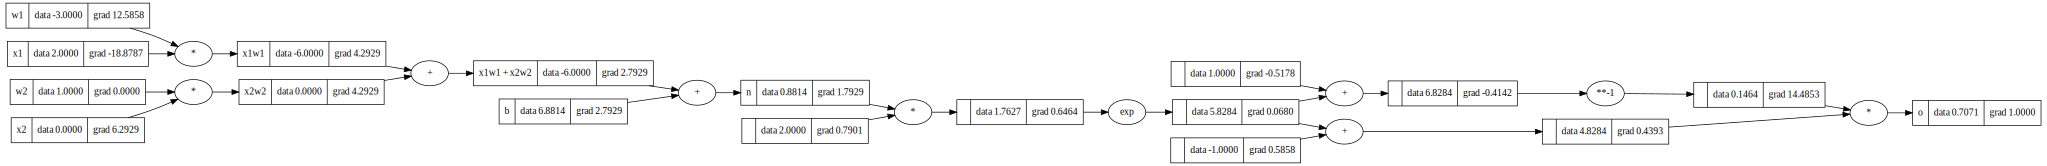

In [14]:
draw_dot(o)

In [15]:

# we have to call the backward function in the topilogical order. The edges go one way from left to right.
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)


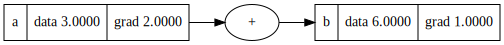

In [11]:
# @title a bug
# b = a + a
# db/da = 2 (not 1)
a = Value(3.0, label="a")
b = a + a
b.label = "b"
b.backward()
draw_dot(b)

In [33]:
a = Value(2.0)
a * 2 # a.__mul__(2)
2 * a # 2.__mul__(a) this doesn't work unless we implement __rmul__ (rmul applies the commutative rule)
a.exp()
b = Value(4.0)
a / b
a - b
2 + a

Value(data=4.0)

In [16]:
# @title Use Pytorch to do backpropagation
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print("----")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [53]:
import random
class Neuron:
  def __init__(self,num_in):
    """
    num_in: number of inputs within one neuron
    if num_in is 2, w1x1 + w2x2 + b = y
    """
    self.w = [Value(random.uniform(-1,1)) for _ in range(num_in)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    #  w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, num_in, num_out):
    """
    num_in: number of input within one neuron
    num_out: number of neurons in the single layer
    """
    self.neurons = [Neuron(num_in) for _ in range(num_out)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      params += neuron.parameters()
    return params

class MLP:
  def __init__(self, num_in, num_out):
    """
    num_in: number of inputs
    num_out: a list consists of a number of neurons in each layer
    """
    sz = [num_in] + num_out
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_out))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
# n = Neuron(2) # triggers __call__
# n = Layer(2, 3)
n = MLP(3, [4, 4, 1])
n(x)
n.parameters()

[Value(data=-0.3298594103690333),
 Value(data=-0.2825661557560526),
 Value(data=0.5607663409450241),
 Value(data=-0.03498088547955058),
 Value(data=0.05298040241425572),
 Value(data=0.2650206768931884),
 Value(data=-0.6239390974398273),
 Value(data=-0.3445965311344541),
 Value(data=0.8932947312389028),
 Value(data=-0.4782030752585058),
 Value(data=-0.11902160432993791),
 Value(data=0.21432456762667318),
 Value(data=-0.24662937702901444),
 Value(data=-0.36897394716902765),
 Value(data=-0.8498103221676987),
 Value(data=-0.18273892508441936),
 Value(data=0.5849460543438407),
 Value(data=-0.8305806920041632),
 Value(data=0.259231209853479),
 Value(data=0.2523231563480173),
 Value(data=-0.3808111071418012),
 Value(data=-0.8204069957639122),
 Value(data=-0.10640563056596086),
 Value(data=0.7375691894218035),
 Value(data=-0.8492823481517582),
 Value(data=-0.7049298694040431),
 Value(data=0.6172729267449637),
 Value(data=-0.9532929648487294),
 Value(data=0.7630258380585129),
 Value(data=-0.413

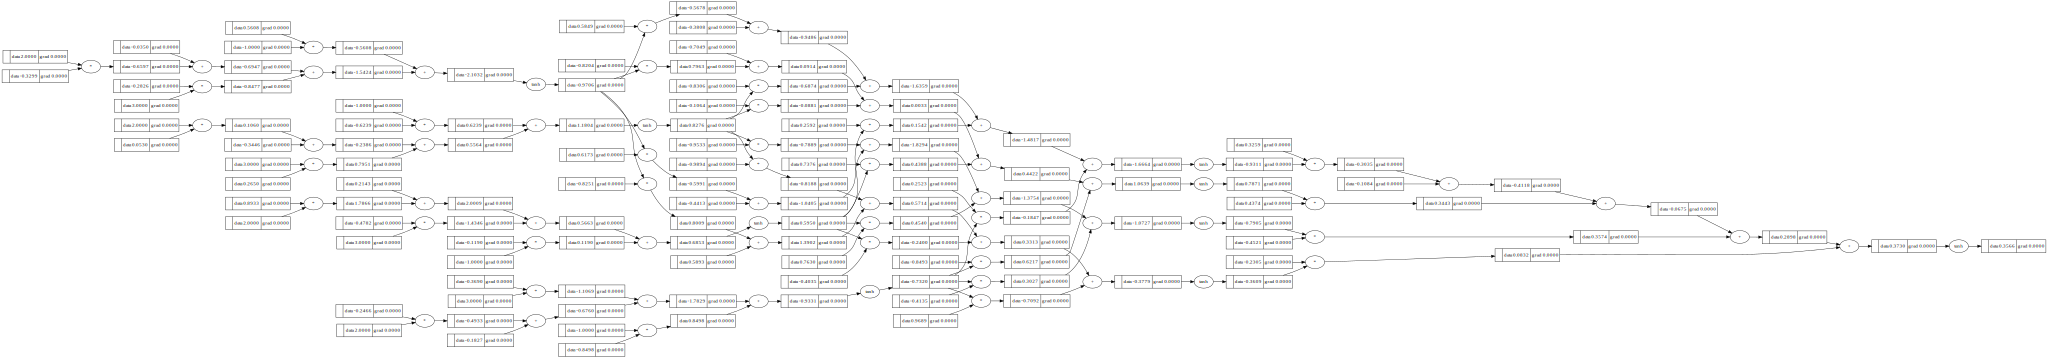

In [54]:
draw_dot(n(x))

In [168]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [82]:
# @title Mean square loss
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.3105631131332522)

In [179]:
# @title Training loop
lr = 0.1 # step size / learning rate
for k in range(50):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -lr * p.grad
  print(k, loss.data)

0 0.00027551119540663525
1 0.0002749652024472974
2 0.0002744213766726493
3 0.00027387970520247415
4 0.00027334017525838095
5 0.0002728027741628383
6 0.0002722674893381639
7 0.00027173430830553695
8 0.0002712032186840396
9 0.0002706742081897114
10 0.0002701472646345517
11 0.00026962237592566155
12 0.0002690995300642432
13 0.00026857871514474464
14 0.00026805991935390953
15 0.0002675431309699188
16 0.0002670283383614978
17 0.00026651552998703575
18 0.0002660046943937279
19 0.0002654958202167396
20 0.00026498889617832417
21 0.00026448391108703273
22 0.000263980853836867
23 0.00026347971340647387
24 0.0002629804788583389
25 0.00026248313933798363
26 0.0002619876840731893
27 0.000261494102373214
28 0.00026100238362803844
29 0.00026051251730757396
30 0.0002600244929609367
31 0.0002595383002157034
32 0.0002590539287771622
33 0.00025857136842760947
34 0.00025809060902559817
35 0.00025761164050525494
36 0.0002571344528755871
37 0.00025665903621973995
38 0.000256185380694355
39 0.000255713476528

In [180]:
ypred

[Value(data=0.9999995748372146),
 Value(data=-0.9845422980180757),
 Value(data=-0.9965145861155409),
 Value(data=0.9999995647332464)]